In [1]:
import sys, os
import json, pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import time as pytime
import statsmodels.tsa.stattools as tsas
import ruptures as rpt
sys.path.append('../..')
import InsanallyLabEphysTools as ilep
from scipy.stats import gaussian_kde, sem, ttest_ind, ttest_rel, norm, mannwhitneyu, linregress, wilcoxon
from tqdm import tqdm
from types import SimpleNamespace
from sklearn import linear_model
from sklearn.model_selection import KFold
import seaborn as sns
import traceback
from itertools import product
from brokenaxes import brokenaxes
import pingouin as pg
import colorsys
from scipy.stats import pearsonr, spearmanr, normaltest
from ipyparallel import Client
import time

from umap import umap_ as umap
import networkx as nx

plt.rcParams['legend.fontsize'] = 'small'
plt.rcParams['axes.labelsize'] = 'medium'
plt.rcParams['axes.formatter.limits'] = [-2,3]
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['figure.dpi'] = '150'

#Set global font parameters
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
#Set font type to TrueType for compatibility
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

TARGET_COLOR = '#ff3654'
NONTARGET_COLOR = '#5776ff'

CR_COLOR = '#808080'
NCR_COLOR = '#FF767C'
CNO_COLOR = '#00BFFF'
SWITCH_COLOR = '#B07A3B'
LASER_COLOR = '#3375E9'
GOOD_GREY = '#969696'
GOOD_GREEN = '#32A852'
NCR_COLOR_DESAT = '#D98C90'
CR_COLOR_DESAT = '#A0A0A0'
NCR_CR_cmap = mpl.colors.LinearSegmentedColormap.from_list('NCR-CR color map', [NCR_COLOR, CR_COLOR], N=1000)
PHASE_COLORS = ['#DEB9E0','#B78AB9','#906D92','#ABC5E8','#869BB7','#5E6C80']#,'#6ded94','#50d979','#36bf5f']

dualanimalnames = ['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_67','BS_70','BS_72','BS_87','BS_108']
danimals = ['DS_15','DS_19','DS_24','DS_27','DS_28']

retroanimals = ['PB_86','BS_86','PB_92','BS_92','BS_100','BS_103','BS_111','BS_119','BS_123','BS_128','BS_131','BS_139','BS_163','BS_165']
did_learn = ['BS_92','BS_103','BS_111','BS_179']
did_not_learn = ['BS_86','BS_100','BS_119','BS_123','BS_128','BS_131','BS_163','BS_174']
indeterminate = ['BS_139','BS_165','BS_191','BS_192']


#BS_59
dualanimalnames = ['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_67','BS_70','BS_72','BS_87','BS_108']#,'DS_15','DS_19']
opsinanimalnames = ['BS_86','BS_92','BS_100','BS_103','BS_111','BS_119','BS_123','BS_128','BS_131','BS_139','BS_163','BS_165','BS_174','BS_179','BS_191','BS_192']
tuninganimalnames = ['BS_173','BS_175','BS_187','BS_188','BS_213','BS_214','TH_217','AE_235','AE_236','TH_237']
unuseddualanimals = ['BS_78']
danimals = ['DS_15','DS_19','DS_24','DS_27','DS_28','DS_16','DS_17','DS_22','DS_13','DS_23']

#act_directory = 'D:\\Analysis_Cache_archived_Oct_27_2022'
act_directory = '..\\..\\Data\\Analysis_Cache'#'C:\\Users\insan\\Desktop\\Analysis_Cache_Aug23'
wav_directory = '..\\..\\Data\\Waveforms_Cache'
beh_directory = '..\\..\\Data\\Behavioor'

stim25sdecodingfilename = 'D:\\stimdecoding_25s.csv'
stim25sopsinondecodingfilename = 'D:\\stimdecoding_25s_opsin_on.csv'
stim25sopsinoffdecodingfilename = 'D:\\stimdecoding_25s_opsin_off.csv'

current_version = 1 #June 22nd, 2023
current_version = 2 #July 11th, 2023
current_version = 3 #July 21th, 2023
current_version = 4 #July 31th, 2023
current_version = 5 #Aug 2nd, 2023
current_version = 6 #Aug 12th, 2023
current_version = 7 #Nov 6th, 2023

stdfont = 14
stdyfrac = 0.06

C:\Users\4thgr\anaconda3\envs\InsanallyLabEnv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
animals = np.concatenate((dualanimalnames,['DS_15','DS_19']))

In [3]:
print(animals)

['BS_40' 'BS_41' 'BS_42' 'BS_49' 'BS_50' 'BS_51' 'BS_56' 'BS_59' 'BS_67'
 'BS_70' 'BS_72' 'BS_87' 'BS_108' 'DS_15' 'DS_19']


In [4]:
animalBehaviors = ilep.getAllBehavior(beh_directory)

Fetching files for BS_51
Fetching files for BS_52
Fetching files for BS_56
Fetching files for BS_59
Fetching files for BS_61
Fetching files for BS_86
Fetching files for BS_92
Fetching files for BS_100
Fetching files for BS_103
Fetching files for BS_111
Fetching files for BS_119
Fetching files for BS_123
Fetching files for BS_128
Fetching files for BS_131
Fetching files for BS_139
Fetching files for BS_163
Fetching files for BS_165
Fetching files for BS_174
Fetching files for BS_179
Fetching files for BS_191
Fetching files for BS_192
Fetching files for BS_33
Fetching files for BS_67
Fetching files for BS_73
Fetching files for BS_78
Fetching files for BS_108
Fetching files for BS_40
Fetching files for BS_41
Fetching files for BS_42
Fetching files for BS_49
Fetching files for BS_50
Fetching files for BS_70
Fetching files for BS_72
Fetching files for BS_83
Fetching files for BS_85
Fetching files for BS_87
Fetching files for BS_95
Fetching files for BS_113
Fetching files for DS_15
Fetching 

C:\Users\4thgr\Documents\TothSidleck2024\Notebooks\Reviewer 1\../..\InsanallyLabEphysTools\behavior.py:94: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be fini

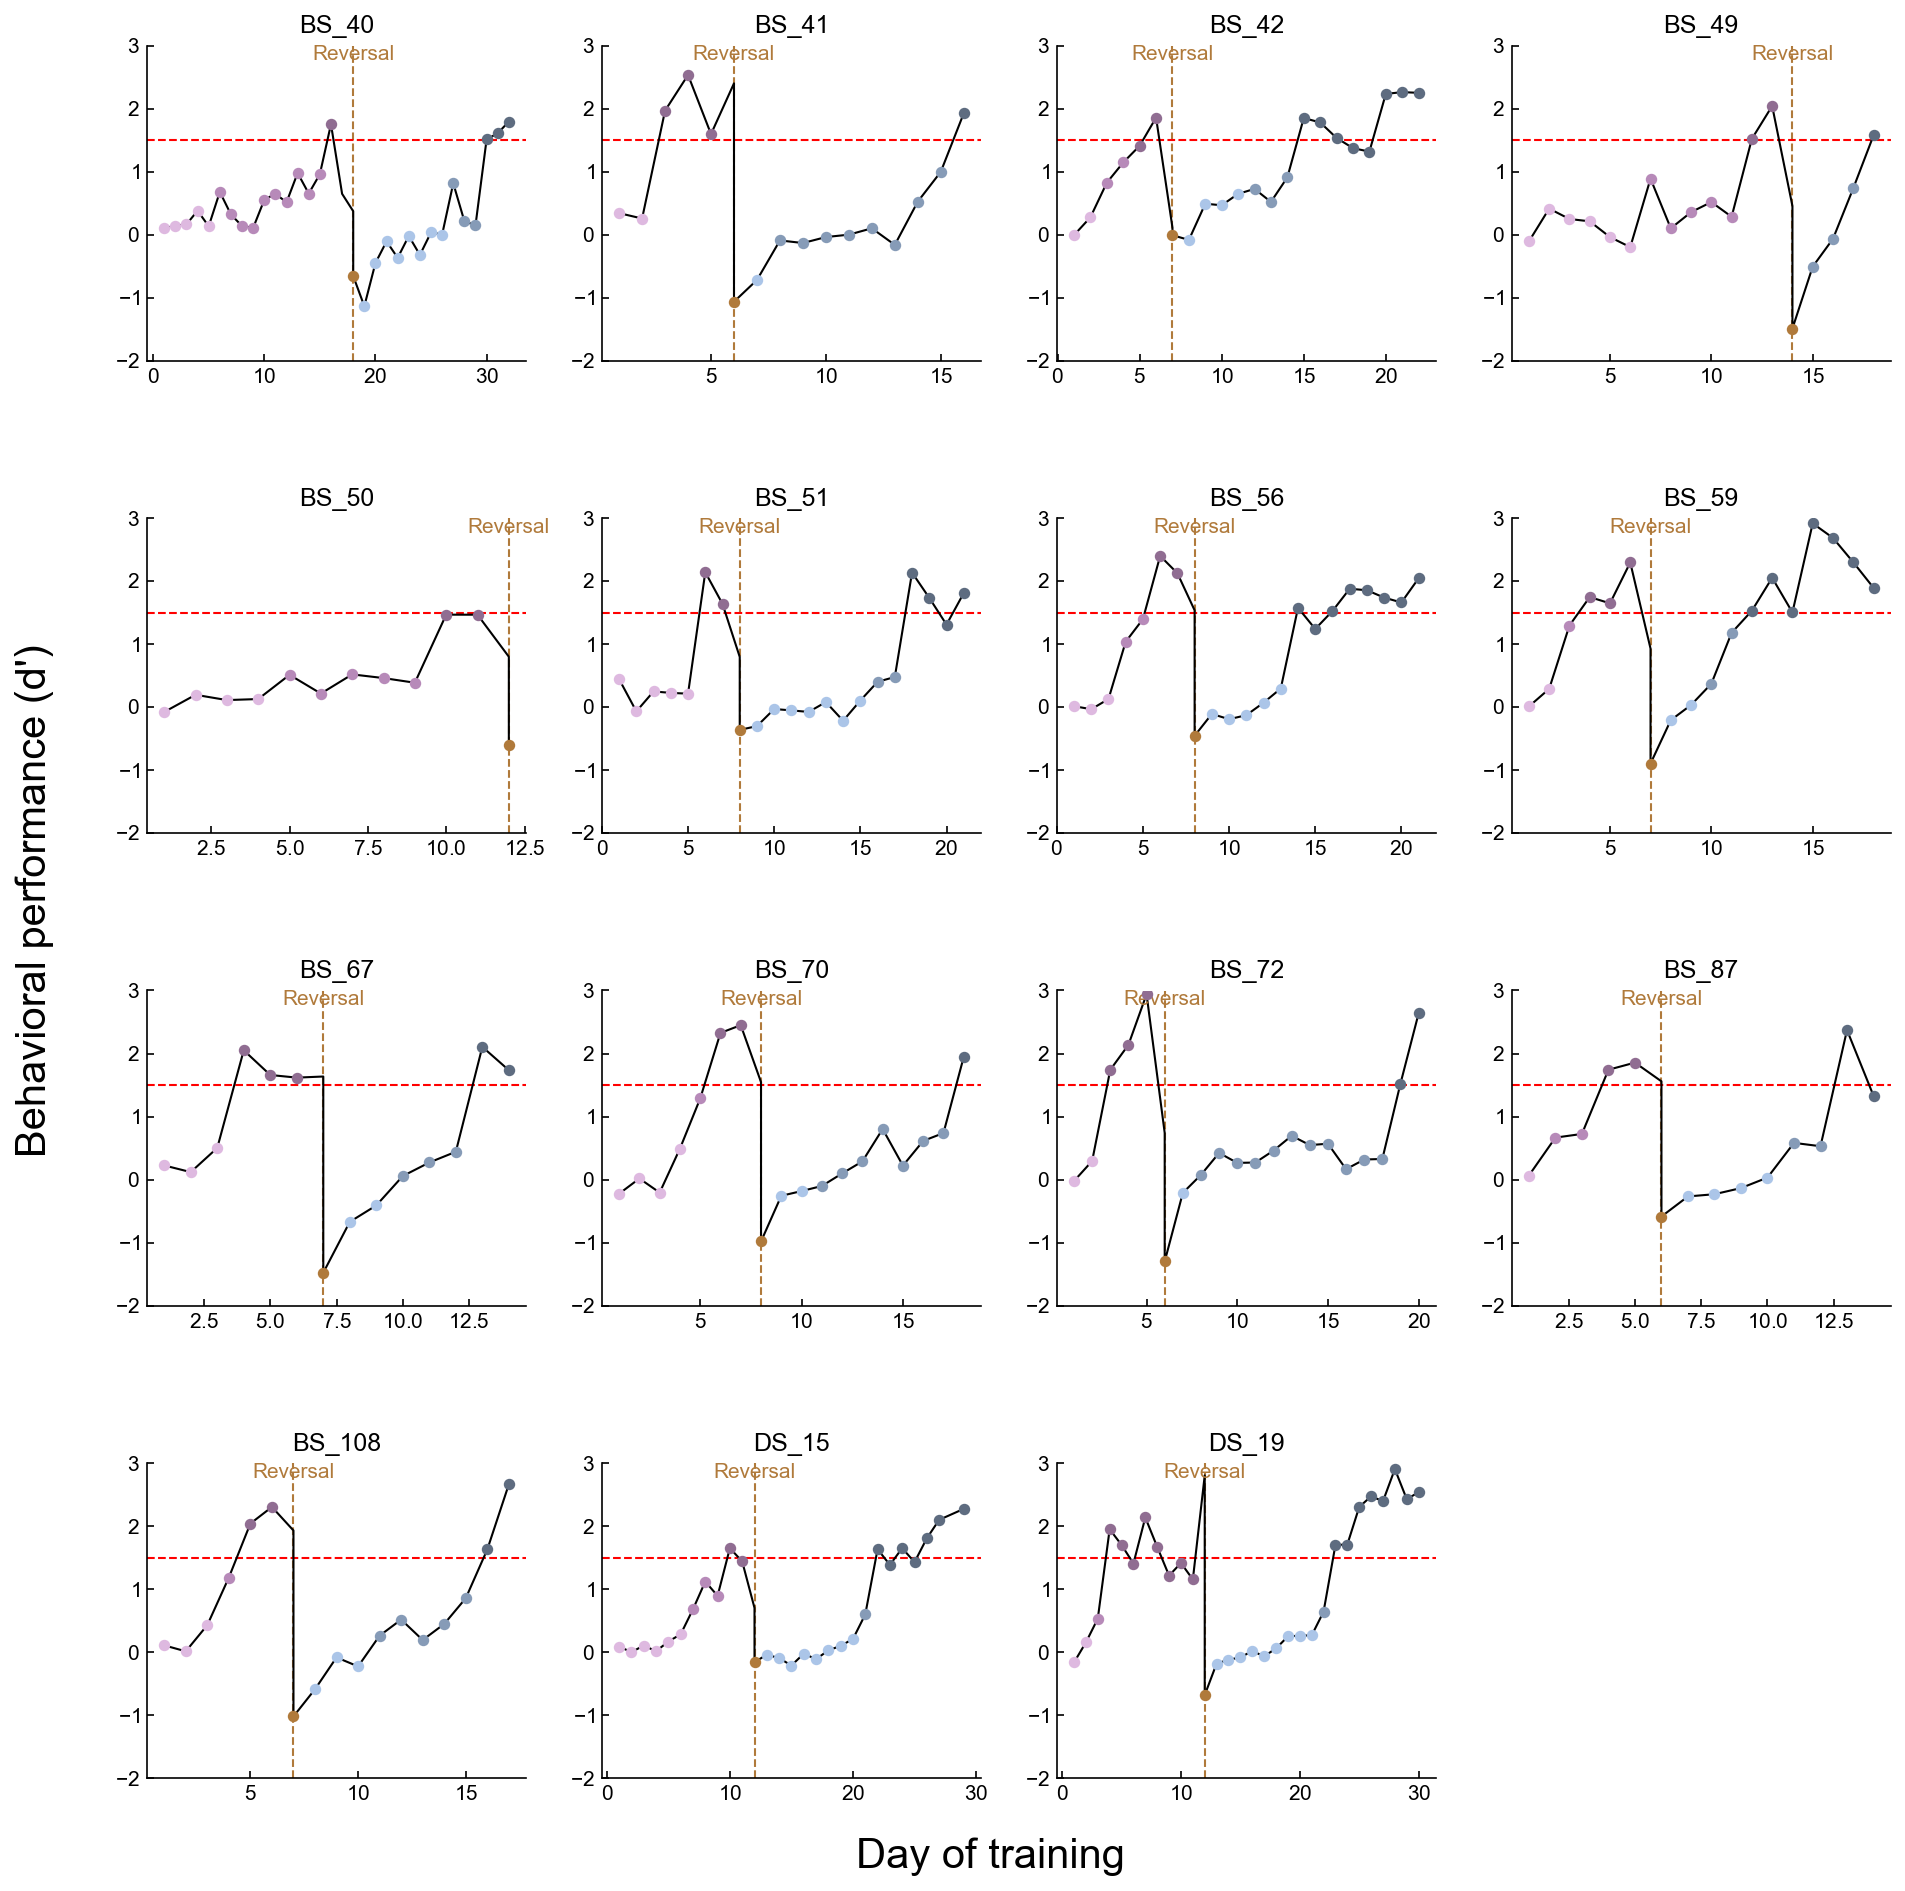

In [5]:
learning_phases,_,_ = ilep.calculateLearningPhasesV2(animals,animalBehaviors,plot=True)
#plt.savefig(os.path.join('D:\\\\TempFigures','All ephys animals learning phases.pdf'),transparent=False,facecolor="white")

In [6]:
EnumSession = []
EnumClust = []
sessions = os.listdir(act_directory)
for session in tqdm(sessions):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    if sessionfile.meta.task in ['passive no behavior']:
        continue
    if sessionfile.meta.task in ['tuning nonreversal','tuning switch','tuning reversal']:
        continue
    if sessionfile.meta.region != 'AC':
        continue
        
    if sessionfile.meta.animal not in animals:
        continue
    
    if sessionfile.meta.animal == 'BS_59':
        print('A')
    
#     EnumSession.append(session)
    for clust in sessionfile.clusters.good:
        EnumSession.append(session)
        EnumClust.append(clust)

100%|██████████| 740/740 [00:36<00:00, 20.41it/s]


In [7]:
EILphases = np.full_like(EnumSession,np.nan)
error_animals = []

for idx,session in enumerate(tqdm(EnumSession)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    try:
        animal = sessionfile.meta.animal
        day = sessionfile.meta.day_of_training
        
        if sessionfile.meta.task in ['switch','opto switch','tuning switch']:
            EILphases[idx] = 'switch'

        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal'] and day in learning_phases[animal].pre_early_days:
            EILphases[idx] = 'pre early'
        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal']  and day in learning_phases[animal].pre_late_days:
            EILphases[idx] = 'pre late'
        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal'] and day in learning_phases[animal].pre_expert_days:
            EILphases[idx] = 'pre expert'

        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal']  and day in learning_phases[animal].post_early_days:
            EILphases[idx] = 'post early'
        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal']  and day in learning_phases[animal].post_late_days:
            EILphases[idx] = 'post late'
        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal']  and day in learning_phases[animal].post_expert_days:
            EILphases[idx] = 'post expert'
    except Exception as e:
        #print(ilep.generateDateString(sessionfile))
        error_animals.append(sessionfile.meta.animal)
        pass
                             
error_animals = np.unique(error_animals)
print('errors for: '+str(error_animals))

100%|██████████| 1829/1829 [01:18<00:00, 23.24it/s]

errors for: []


Abnormal crossings detected at BS_42_6_AC.pickle cluster 73


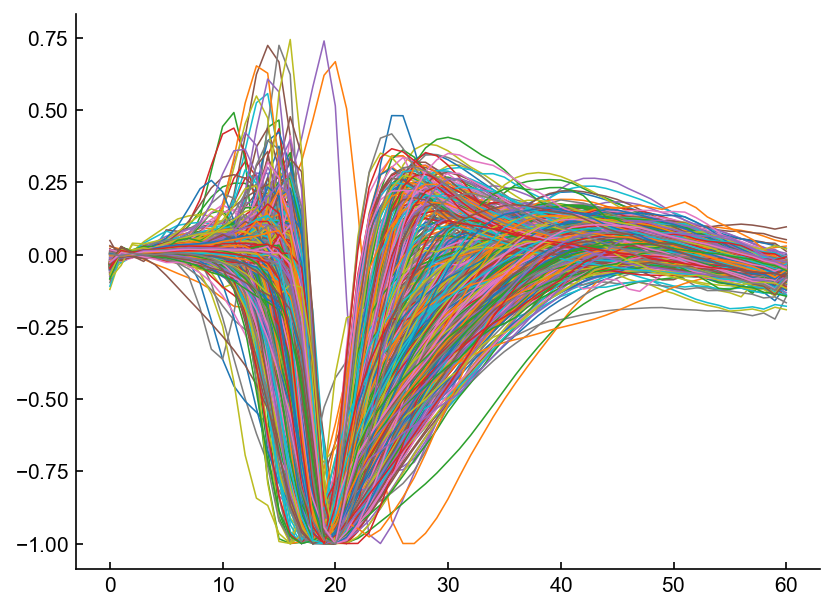

In [16]:
FRmods = []
half_widths = []

for session,clust in zip(EnumSession,EnumClust):
    session_prefix = session[:-7]
    session_waveform = session_prefix+'_waveforms.pickle'

    sessionfile = ilep.loadSessionCached(act_directory,session)
    try:
        with open(os.path.join(wav_directory,session_waveform), 'rb') as f:
            waveforms = pickle.load(f)
    except Exception as e:
        # print(f"failed to find {session_waveform}: {e}")
        continue
        pass

    waveform = waveforms[clust]

    if np.min(waveform) > -0.9 or np.max(waveform) > 0.9:
        continue

    plt.plot(waveform,lw=0.75)

    sample_of_trough = np.argmin(waveform)
    half_width_crossings = np.where(np.diff(np.sign(waveform + 0.5)))[0]
    if len(half_width_crossings) != 2:
        print(f"Abnormal crossings detected at {session} cluster {clust}")
        continue
    half_width_ms = np.ptp(half_width_crossings) / 30

    half_widths.append(half_width_ms)
    FRmods.append(sessionfile.responsiveness[clust]['all_trials'].FRmodulation)

plt.savefig('C:\\Users\\4thgr\\Downloads\\Allwaveforms.pdf')

# Wavemap

In [8]:
UMAP_reducer_seed = 42
louvain_seed = 80

In [9]:
normWFs = []
for session,clust in zip(EnumSession,EnumClust):
    session_prefix = session[:-7]
    session_waveform = session_prefix+'_waveforms.pickle'

    sessionfile = ilep.loadSessionCached(act_directory,session)
    try:
        with open(os.path.join(wav_directory,session_waveform), 'rb') as f:
            waveforms = pickle.load(f)
    except Exception as e:
        # print(f"failed to find {session_waveform}: {e}")
        continue
        pass

    waveform = waveforms[clust]

    if np.min(waveform) > -0.9 or np.max(waveform) > 0.9:
        continue
        
    sample_of_trough = np.argmin(waveform)
    half_width_crossings = np.where(np.diff(np.sign(waveform + 0.5)))[0]
    if len(half_width_crossings) != 2:
        print(f"Abnormal crossings detected at {session} cluster {clust}")
        continue
    half_width_ms = np.ptp(half_width_crossings) / 30

    normWFs.append(waveforms[clust])
normWFs = np.array(normWFs)
# normWFs = np.full((len(subset_df),53),np.nan)
# for idx,UUID in enumerate(subset_df.index):
#     normWFs[idx,:] = subset_df.loc[UUID]['mean waveform']

Abnormal crossings detected at BS_42_6_AC.pickle cluster 73


In [10]:
normWFs.shape

(877, 61)

In [11]:
reducer = umap.UMAP(n_neighbors=15, random_state=UMAP_reducer_seed,n_jobs=1)
mapper = reducer.fit(normWFs)

G = nx.from_scipy_sparse_array(mapper.graph_)
temp_solution = nx.community.louvain_communities(G,resolution = 0.8,seed=80)
# print(np.sum([(len(l) for l in clustering_solution]))

clustering_solution = np.full_like(list(G.nodes),np.nan)
for idx in range(len(clustering_solution)):
    membership = [np.isin(idx,list(t)) for t in temp_solution]
    cluster_ID = np.where(membership)[0]
    clustering_solution[idx] = cluster_ID

modularity = nx.algorithms.community.quality.modularity(G, temp_solution)
print(modularity)

0.7258528789869969


# Broad / Narrow

In [12]:
narrow_clusters = [0,4]
broad_clusters = [1,2,3,5,6,7,8,9]

new_clustering_solution = np.zeros_like(clustering_solution)
narrow_mask = np.isin(clustering_solution,narrow_clusters)
broad_mask = np.isin(clustering_solution,broad_clusters)
new_clustering_solution[broad_mask] += 1

C:\Users\4thgr\AppData\Local\Temp\ipykernel_26196\2742991172.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap('turbo')
C:\Users\4thgr\AppData\Local\Temp\ipykernel_26196\2742991172.py:44: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(X,Y, marker='o', c=rgba,zorder=0,s=30,lw=1.5)


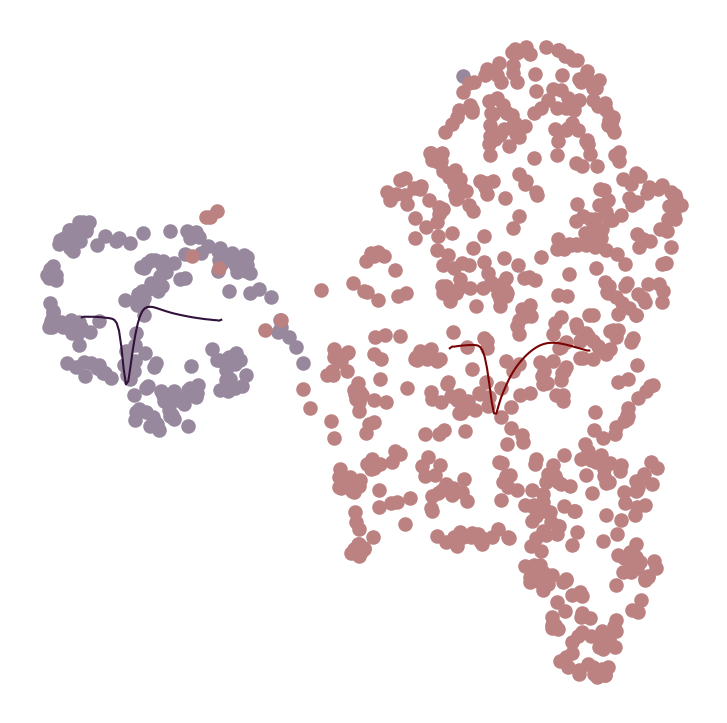

In [14]:
embedding = reducer.fit_transform(normWFs)
umap_df = pd.DataFrame(embedding, columns=('x', 'y'))
umap_df['waveform'] = list(normWFs)
umap_df['cluster_id'] = clustering_solution

fig,ax = plt.subplots(figsize=(6,6))
ax.spines[['left','right','top','bottom']].set_visible(False)
X = np.array(umap_df['x'].tolist())
Y = np.array(umap_df['y'].tolist())
xlim = [np.min(X)-np.ptp(X)*0.05,np.max(X)+np.ptp(X)*0.05]
ylim = [np.min(Y)-np.ptp(Y)*0.05,np.max(Y)+np.ptp(Y)*0.05]
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_xticks([])
ax.set_yticks([])
ax.fill_between(xlim,ylim[0],ylim[1],lw=0,fc='white',alpha=0.5,zorder=4)

unique_waveform_clusters = np.unique(new_clustering_solution)
for wfclust in unique_waveform_clusters:

    #Calculate clustering of points
    mask = new_clustering_solution == wfclust

    X = np.array(umap_df['x'].tolist())
    Y = np.array(umap_df['y'].tolist())
    X = X[mask]
    Y = Y[mask]

    #Calculate waveform
    clust_waveforms = normWFs[mask,:]
    mean_waveform = np.mean(clust_waveforms,axis=0)
    sem_waveform = sem(clust_waveforms,axis=0)

    #Calculate color
    cmap = mpl.cm.get_cmap('turbo')
    rgba = cmap(wfclust/np.max(unique_waveform_clusters))

    # #FRmod colors
    # mn = 3.5
    # spread = 2.5
    # colors = NCR_CR_cmap( (np.array(FRmods)[mask]-(mn-spread/2))/ (spread) )

    #Plot scatter
    ax.scatter(X,Y, marker='o', c=rgba,zorder=0,s=30,lw=1.5)

    #Plot waveform
    meanX = np.mean(X)
    meanY = np.mean(Y)
    total_x_range = np.abs(xlim[1]-xlim[0])
    total_y_range = np.abs(ylim[1]-ylim[0])
    xrange = np.linspace(meanX-total_x_range*0.1,meanX+total_x_range*0.1,num=61)
    y_adj = mean_waveform * total_y_range*0.1 + meanY
    ysem_adj = sem_waveform * total_y_range*0.1
    ax.plot(xrange,y_adj,c=rgba,lw=1,zorder=5)
    ax.fill_between(xrange,y_adj-ysem_adj,y_adj+ysem_adj,alpha=1,lw=0,fc=rgba,zorder=4)

plt.savefig('C:\\Users\\4thgr\\Downloads\\WavemapClustersNarrowBroad.pdf')

C:\Users\4thgr\AppData\Local\Temp\ipykernel_26196\1879317394.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap('turbo')
C:\Users\4thgr\AppData\Local\Temp\ipykernel_26196\1879317394.py:34: RuntimeWarning: divide by zero encountered in log10
  X,_ = ilep.violin(np.log10(np.array(FRmods)[mask]))
C:\Users\4thgr\AppData\Local\Temp\ipykernel_26196\1879317394.py:36: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(X+Xpos,Y, marker='o', c=rgba,zorder=0,clip_on=False)


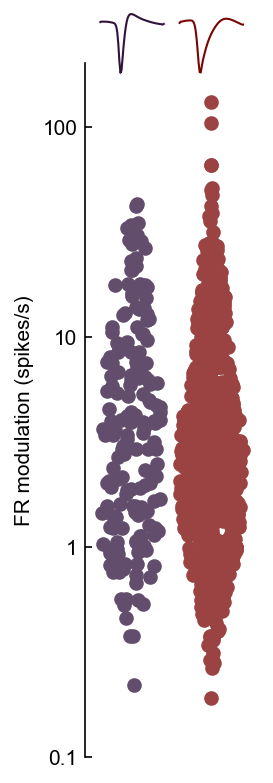

In [17]:
# embedding = reducer.fit_transform(normWFs)
# umap_df = pd.DataFrame(embedding, columns=('x', 'y'))
# umap_df['waveform'] = list(normWFs)
# umap_df['cluster_id'] = clustering_solution

fig,ax = plt.subplots(figsize=(1.5,6))
ax.spines[['right','top','bottom']].set_visible(False)
ax.set_xticks([])
ax.set_ylabel('FR modulation (spikes/s)')
ax.set_yscale('log',subs=[])
ax.set_ylim([0.1,200])
ax.set_yticks([0.1,1,10,100])
ax.set_yticklabels(['0.1','1','10','100'])
xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.fill_between([-0.5,1.5],ylim[0],ylim[1],lw=0,fc='white',alpha=0.25,zorder=4)

unique_waveform_clusters = np.unique(new_clustering_solution)
for Xpos,wfclust in enumerate(unique_waveform_clusters):

    #Calculate clustering of points
    mask = new_clustering_solution == wfclust

    #Calculate waveform
    clust_waveforms = normWFs[mask,:]
    mean_waveform = np.mean(clust_waveforms,axis=0)
    sem_waveform = sem(clust_waveforms,axis=0)
    
    #Calculate color
    cmap = mpl.cm.get_cmap('turbo')
    rgba = cmap(wfclust/np.max(unique_waveform_clusters))
    
    #Plot scatter
    X,_ = ilep.violin(np.log10(np.array(FRmods)[mask]))
    Y = np.array(FRmods)[mask]
    ax.scatter(X+Xpos,Y, marker='o', c=rgba,zorder=0,clip_on=False)

    #Plot waveform
    meanX = Xpos
    meanY = 2.5
    total_x_range = 0.4
    total_y_range = 0.25
    xrange = np.linspace(meanX-total_x_range,meanX+total_x_range,num=61)
    y_adj = mean_waveform * total_y_range + meanY
    ysem_adj = sem_waveform * total_y_range
    ax.plot(xrange,10**(y_adj),c=rgba,lw=1,zorder=5,clip_on=False)
    ax.fill_between(xrange,10**(y_adj-ysem_adj),10**(y_adj+ysem_adj),alpha=1,lw=0,fc=rgba,zorder=4,clip_on=False)

# ax.plot([2.5]*2,[-500,4000],c='k',alpha=0.1,lw=1,zorder=-10,clip_on=False)
# ax.plot([3.5]*2,[-500,4000],c='k',alpha=0.1,lw=1,zorder=-10,clip_on=False)
# ax.plot([7.5]*2,[-500,4000],c='k',alpha=0.1,lw=1,zorder=-10,clip_on=False)
# ax.text(1,-500,'Broad',verticalalignment='bottom',horizontalalignment='center',clip_on=False)
# ax.text(3,-500,'N. Biphasic',verticalalignment='bottom',horizontalalignment='center',clip_on=False)
# ax.text(5.5,-500,'N. Triphasic',verticalalignment='bottom',horizontalalignment='center',clip_on=False)
# ax.text(8,-500,'Upward(?)',verticalalignment='bottom',horizontalalignment='center',clip_on=False)
# pass

plt.savefig('C:\\Users\\4thgr\\Downloads\\WavemapClustersVsFRmodNarrowBroad.pdf')

In [19]:
narrow_FRmod = ilep.rmnan(np.array(FRmods)[narrow_mask])
broad_FRmod = ilep.rmnan(np.array(FRmods)[broad_mask])

In [20]:
normaltest(narrow_FRmod)

NormaltestResult(statistic=87.4761595309171, pvalue=1.0110981338277003e-19)

In [21]:
normaltest(broad_FRmod)

NormaltestResult(statistic=842.1197794942641, pvalue=1.3677708129591198e-183)

In [22]:
mannwhitneyu(narrow_FRmod,broad_FRmod)

MannwhitneyuResult(statistic=66289.0, pvalue=0.14520950711327502)

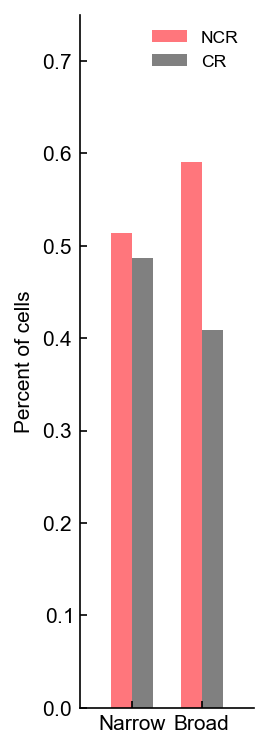

In [23]:
# embedding = reducer.fit_transform(normWFs)
# umap_df = pd.DataFrame(embedding, columns=('x', 'y'))
# umap_df['waveform'] = list(normWFs)
# umap_df['cluster_id'] = clustering_solution

fig,ax = plt.subplots(figsize=(1.5,6))
ax.spines[['right','top']].set_visible(False)
ax.set_xticks([0,1])
ax.set_xticklabels(['Narrow','Broad'])

ax.set_ylabel('Percent of cells')
ax.set_ylim([0,0.75])
xlim = [-0.75,1.75]
ax.set_xlim(xlim)
ylim = ax.get_ylim()
# ax.fill_between([-0.5,9.5],ylim[0],ylim[1],lw=0,fc='white',alpha=0.25,zorder=4)

narrow_pNCR = np.mean(np.less(narrow_FRmod,3.5))
broad_pNCR = np.mean(np.less(broad_FRmod,3.5))
ax.bar(np.array([0,1])-0.15,[narrow_pNCR,broad_pNCR],width=0.3,fc=NCR_COLOR,lw=0)
ax.bar(np.array([0,1])+0.15,[1-narrow_pNCR,1-broad_pNCR],width=0.3,fc=CR_COLOR,lw=0)

ax.fill_between([],[],[],fc=NCR_COLOR,label='NCR')
ax.fill_between([],[],[],fc=CR_COLOR,label='CR')
ax.legend(frameon=False)

# plt.savefig('C:\\Users\\4thgr\\Downloads\\WavemapClustersVsFRmod.pdf')

C:\Users\4thgr\AppData\Local\Temp\ipykernel_26196\2285001599.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap('turbo')
C:\Users\4thgr\AppData\Local\Temp\ipykernel_26196\2285001599.py:29: RuntimeWarning: divide by zero encountered in log10
  A = ilep.rmnan(np.log10(narrow_FRmod))


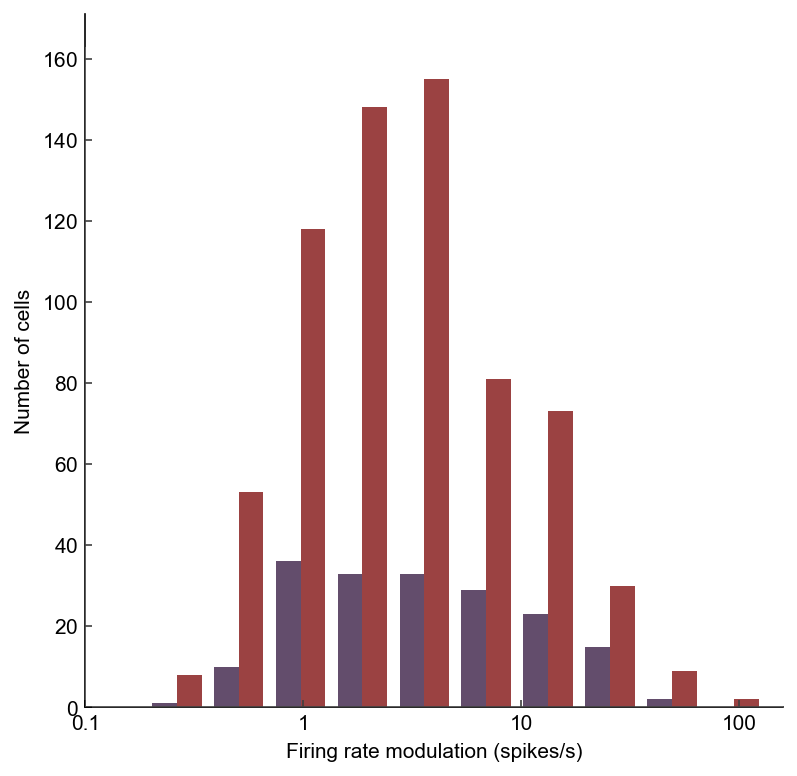

In [24]:
# embedding = reducer.fit_transform(normWFs)
# umap_df = pd.DataFrame(embedding, columns=('x', 'y'))
# umap_df['waveform'] = list(normWFs)
# umap_df['cluster_id'] = clustering_solution

fig,ax = plt.subplots(figsize=(6,6))
ax.spines[['right','top']].set_visible(False)
# ax.set_xticks([0,1])
# ax.set_xticklabels(['Narrow','Broad'])

# ax.set_ylabel('Percent of cells')
# ax.set_ylim([0,0.75])
# xlim = [-0.75,1.75]
# ax.set_xlim(xlim)
# ylim = ax.get_ylim()
# ax.fill_between([-0.5,9.5],ylim[0],ylim[1],lw=0,fc='white',alpha=0.25,zorder=4)

# narrow_pNCR = np.mean(np.less(narrow_FRmod,3.5))
# broad_pNCR = np.mean(np.less(broad_FRmod,3.5))
# ax.bar(np.array([0,1])-0.15,[narrow_pNCR,broad_pNCR],width=0.3,fc=NCR_COLOR,lw=0)
# ax.bar(np.array([0,1])+0.15,[1-narrow_pNCR,1-broad_pNCR],width=0.3,fc=CR_COLOR,lw=0)

# ax.fill_between([],[],[],fc=NCR_COLOR,label='NCR')
# ax.fill_between([],[],[],fc=CR_COLOR,label='CR')
# ax.legend(frameon=False)

cmap = mpl.cm.get_cmap('turbo')

A = ilep.rmnan(np.log10(narrow_FRmod))
B = ilep.rmnan(np.log10(broad_FRmod))
TEMP_narrow = np.full_like(B,np.nan)
TEMP_narrow[range(len(A))] = A
ax.hist([TEMP_narrow,B],bins=10,color=[cmap(0.0),cmap(1.0)])

xlim = [-1,2.2]
ax.set_xlim(xlim)
ax.set_xticks([-1,0,1,2])
ax.set_xticklabels(['0.1','1','10','100'])
ax.set_xlabel('Firing rate modulation (spikes/s)')

ax.set_ylabel('Number of cells')
ylim = ax.get_ylim()

ax.fill_between(xlim,ylim[0],ylim[1],lw=0,fc='white',alpha=0.25,zorder=4)

# plt.savefig('C:\\Users\\4thgr\\Downloads\\WavemapClustersVsFRmod.pdf')